# Temporal analysis of the data 

Following the EDA, I will perform a temporal analysis on the ridership data. 

In [1]:
INSTALL_LIB = True

In [2]:
# libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests

In [3]:
file_name = "TPG_meteo_all_df.csv"
TPG_meteo_all_df = pd.read_csv(file_name,sep=",")

TPG_meteo_all_df['date'] = pd.to_datetime(TPG_meteo_all_df['date'])
display(TPG_meteo_all_df.info())
print(f"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858272 entries, 0 to 4858271
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   ligne                        object        
 2   ligne_type_act               object        
 3   horaire_type                 object        
 4   arret_code_long              object        
 5   indice_semaine               int64         
 6   indice_jour_semaine          int64         
 7   nb_de_montees                float64       
 8   nb_de_descentes              float64       
 9   annee                        int64         
 10  mois                         int64         
 11  log_montees                  float64       
 12  log_descentes                float64       
 13  frequentation_totale         float64       
 14  log_frequentation_totale     float64       
 15  delta_montees_descentes      float64       
 16  

None

# 1) Stops over time

We will look at the passenger counts at a stop (for one code) over time.  
Are some stops present only for a short period?  

In [4]:
periode_arrets = TPG_meteo_all_df.groupby('arret_code_long')['date'].agg(['min', 'max'])
periode_arrets['duree_jours'] = (periode_arrets['max'] - periode_arrets['min']).dt.days
periode_arrets_sorted = periode_arrets.sort_values(by='duree_jours')
#display(periode_arrets_sorted[periode_arrets_sorted['duree_jours'] < 10])
display(periode_arrets_sorted.head(10))
display(periode_arrets_sorted.tail(10))

,min,max,duree_jours
arret_code_long,,,
AUGSST,2024-01-02,2024-01-02,0
CCOL99,2024-05-05,2024-05-05,0
LOUR99,2022-07-17,2022-07-17,0
MEPR03,2025-05-04,2025-05-04,0
MOIL98,2024-10-18,2024-10-18,0
CYTE98,2022-07-17,2022-07-17,0
DEST,2024-12-06,2024-12-06,0
DJST,2025-04-24,2025-04-24,0
PRPI98,2023-05-07,2023-05-07,0


,min,max,duree_jours
arret_code_long,,,
LYIN00,2021-08-01,2025-06-22,1421
CBRI00,2021-08-01,2025-06-22,1421
CBRI01,2021-08-01,2025-06-22,1421
CCAP00,2021-08-01,2025-06-22,1421
CCAP01,2021-08-01,2025-06-22,1421
LULY06,2021-08-01,2025-06-22,1421
LULY05,2021-08-01,2025-06-22,1421
LULY04,2021-08-01,2025-06-22,1421
LYON01,2021-08-01,2025-06-22,1421


In [5]:
periode_arrets_sorted['duree_jours'].value_counts().sort_index()

0         28
1          3
8          7
9          1
10         1
        ... 
1417       1
1418      65
1419      43
1420      34
1421    1569
Name: duree_jours, Length: 208, dtype: int64

### Observation :  
The maximum duration of a stop is 1,421 days.  
Some stops have a lifetime of 0 days, while others have data for 1,421 days.  
Most stops reach this maximum of 1,421 days.  

### Question :  
What is the distribution of the operating duration of stops?  

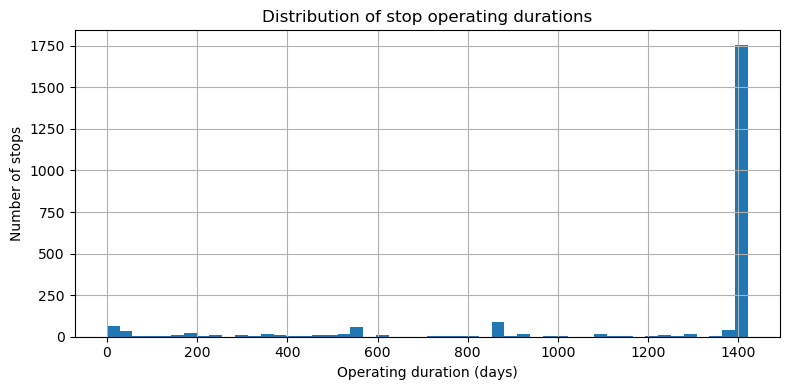

In [6]:
plt.figure(figsize=(8, 4))
periode_arrets_sorted['duree_jours'].hist(bins=50)
plt.xlabel("Operating duration (days)")
plt.ylabel("Number of stops")
plt.title("Distribution of stop operating durations")
plt.tight_layout()
plt.show()

### Observation :  
Most stops have a duration around 1,400 days.  
There is also a spread of durations across many stops.  

### Action :  
A pie chart will be used for representation.  

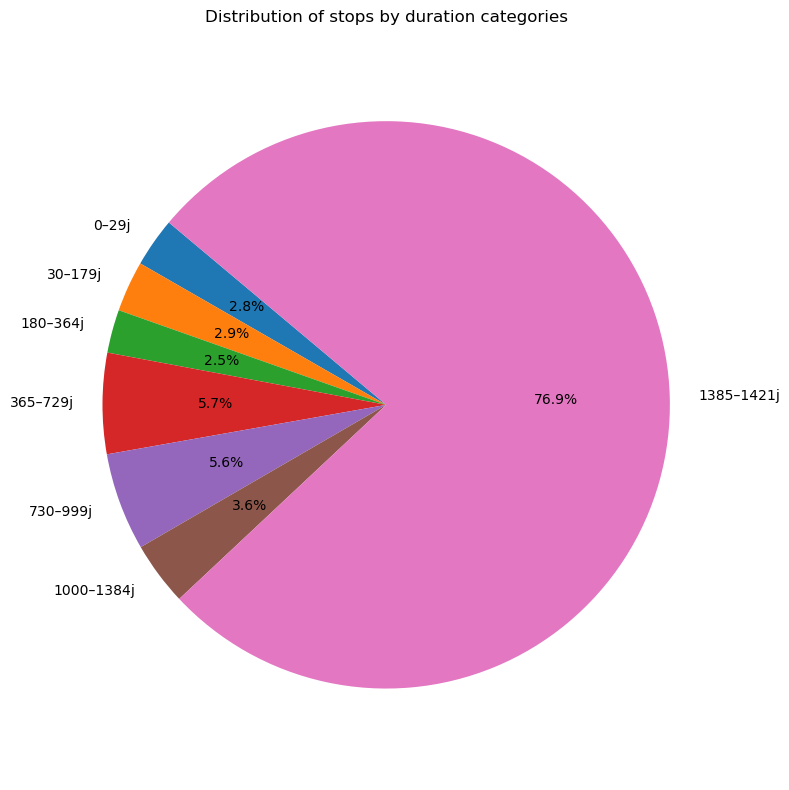

In [7]:
#code from chatGPT after debug
# Créer des classes personnalisées
max_duree = periode_arrets_sorted['duree_jours'].max()

bins = [0, 30, 180, 365, 730, 1000, 1385, max_duree + 1]
labels = [f"{bins[i]}–{bins[i+1]-1}j" for i in range(len(bins)-1)]

periode_arrets_sorted['duree_classe'] = pd.cut(periode_arrets_sorted['duree_jours'], bins=bins, labels=labels, include_lowest=True)

# Compter les classes
classe_counts = periode_arrets_sorted['duree_classe'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    classe_counts.values,
    labels=classe_counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Distribution of stops by duration categories")
plt.axis('equal')
plt.tight_layout()
plt.show()

### Observation :  
- The majority of stops (≈77%) have a duration close to the maximum, i.e. **1421 days**.  
- The remaining stops are very scattered, with many short durations, mostly **less than one year**.  
- The histogram shows a **clear drop before 365 days**, followed by a few small "peaks" around **600** and **800 days**.  

Setting a threshold at **365 days** removes about **8% of stops** (0–30d, 31–180d, 181–365d), and keeps **92% of stops** with a sufficiently long operating duration.  

### Action :  
Remove the stops with less than 365 days of data.  


In [8]:
print(f"Shape before drop arret : {TPG_meteo_all_df.shape}")
seuil_jours = 365
TPG_meteo_all_df = TPG_meteo_all_df[TPG_meteo_all_df['arret_code_long'].isin(
    periode_arrets_sorted[periode_arrets_sorted['duree_jours'] >= seuil_jours].index
)]

print(f"Shape after drop arret : {TPG_meteo_all_df.shape}")

Shape before drop arret : (4858272, 19)
Shape after drop arret : (4837299, 19)


# 2) Stops with the highest passenger counts

### Method :  
Group the dataset by 'arret_code_long' and compute the mean of 'nb_de_montees' per stop over the whole period.  


In [9]:
# Moyenne des montées par arrêt
montees_par_arret = TPG_meteo_all_df.groupby('arret_code_long')['nb_de_montees'].mean().sort_values(ascending=False)

print(montees_par_arret.describe())

count    2129.000000
mean      139.617559
std       308.645100
min         0.000000
25%         4.534425
50%        24.958146
75%       125.847210
max      4057.307792
Name: nb_de_montees, dtype: float64


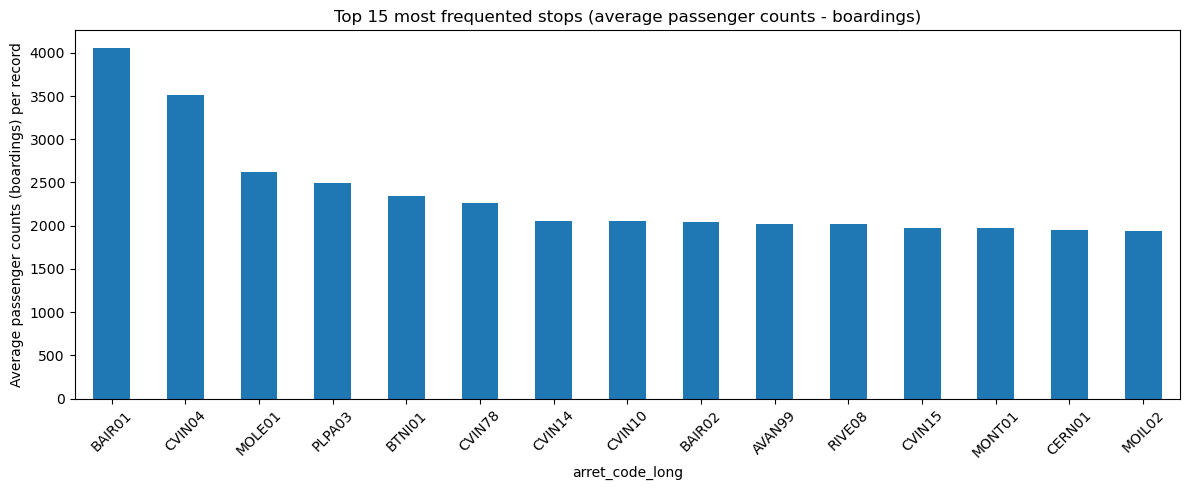

In [10]:
# Display the 15 most frequented stops
montees_par_arret.head(15).plot(
    kind='bar',
    figsize=(12,5),
    title="Top 15 most frequented stops (average passenger counts - boardings)"
)
plt.ylabel("Average passenger counts (boardings) per record")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Leading stops :  

- **BAIR01 (Bel-Air)** with more than 4,000 average passenger counts (boardings) per record.  
- **CVIN04 (Cornavin train station)** follows closely (~3,500).  
- Then there is a gradual decline down to the 15th stop, **CERN01**, around 1,900 boardings.  

There is a minority of stops with very high traffic (major hubs).  
The majority of other stops have much lower passenger counts.  

This type of distribution is typical of a star-shaped or centralized transport system, organized around a few major nodes (e.g., train stations, Bel-Air, Plainpalais).  

# 3) Temporal analysis of ridership

### Observation :  
In the study of line 12, we saw recurring patterns:  
- a drop during vacation periods,  
- an increase in passenger counts (boardings) from September to December.  

### Question :  
Do we observe the same patterns at the global ridership level? 

In [11]:
# agreger les données 
global_daily_df = TPG_meteo_all_df.groupby('date')[['nb_de_montees', 'nb_de_descentes']].sum().reset_index()
global_daily_df['frequentation_totale'] = global_daily_df['nb_de_montees'] + global_daily_df['nb_de_descentes']

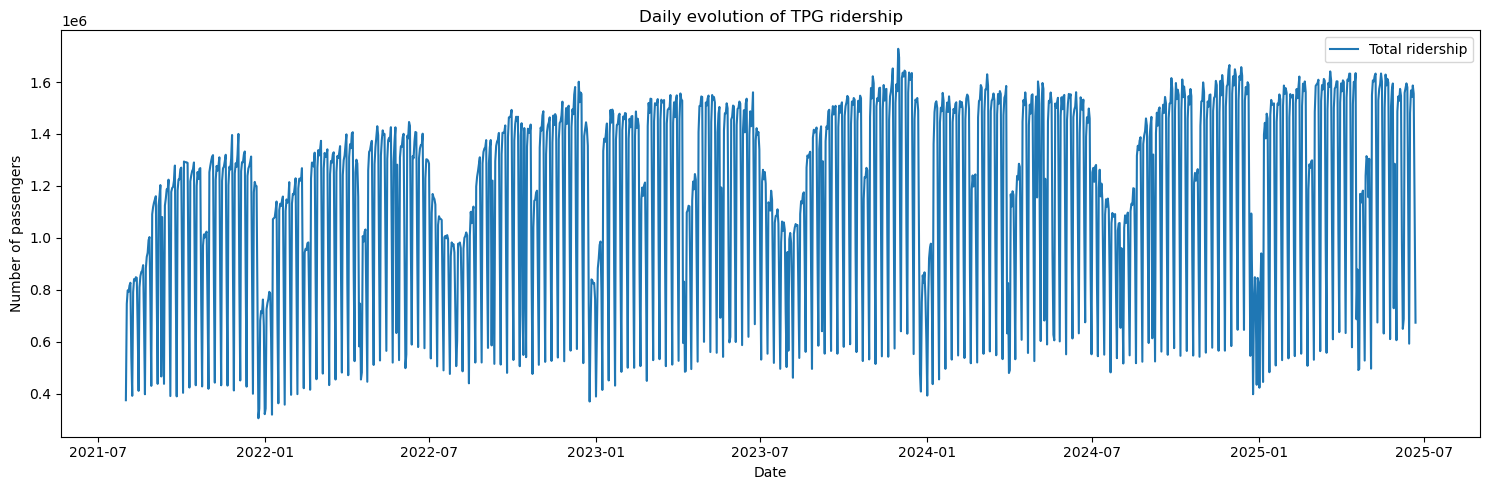

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(global_daily_df['date'], global_daily_df['frequentation_totale'], label='Total ridership')
plt.title("Daily evolution of TPG ridership")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.legend()
plt.tight_layout()
plt.show()

### Observation :  
We can see:  
- a strong weekly seasonality (sawtooth pattern → weekday/weekend effect),  
- recurring drops probably corresponding to vacation periods or public holidays,  
- a general upward trend over several years.  

These same characteristics were already observed on line 12.  



## Resampling

In [13]:
df = global_daily_df.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

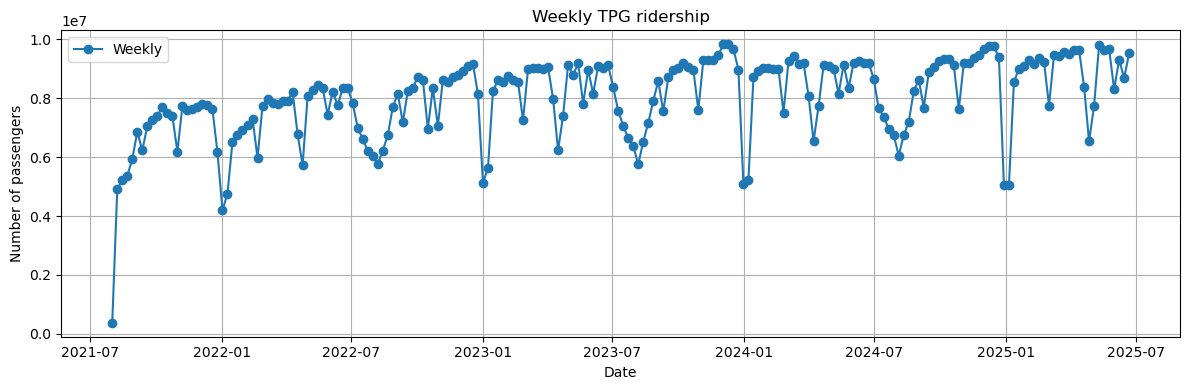

In [14]:
df_weekly = df.resample('W').sum() 
df_monthly = df.resample('M').sum()

plt.figure(figsize=(12, 4))
plt.plot(df_weekly.index, df_weekly['frequentation_totale'], marker='o', label='Weekly')
plt.title("Weekly TPG ridership")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Observation :  

**General trend:**  
A clear increase from 2021 to 2025, with a stabilization effect in the most recent years.  

**Regular drops:**  
Sharp declines each year (December–January, July–August), typically linked to vacation periods or end-of-year holidays.  

**Lower initial values:**  
The beginning of the series (summer 2021) shows lower values, possibly due to a progressive setup of sensors or post-COVID restrictions.  


## Monthly vs day-of-week heatmap

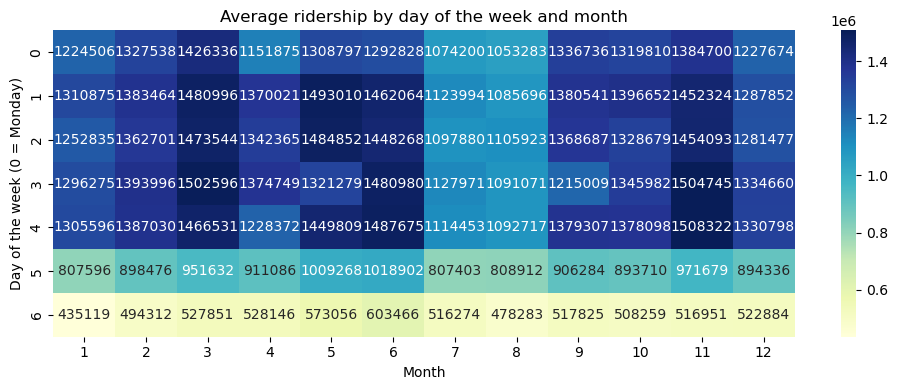

In [15]:
df['dayofweek'] = df.index.dayofweek  # 0=Monday
df['month'] = df.index.month
pivot = df.pivot_table(index='dayofweek', columns='month', values='frequentation_totale', aggfunc='mean')

import seaborn as sns
plt.figure(figsize=(10, 4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average ridership by day of the week and month")
plt.xlabel("Month")
plt.ylabel("Day of the week (0 = Monday)")
plt.tight_layout()
plt.show()

### Reading the heatmap  

- **Y-axis (vertical):** 0 = Monday, up to 6 = Sunday  
- **X-axis (horizontal):** 1 to 12 → months from January to December  
- **Color scale:** the darker the color, the higher the ridership  

### Key observations  

- **High ridership on weekdays (Monday to Friday):**  
  Days 0 to 4 are much darker compared to day 5 (Saturday) and especially day 6 (Sunday).  
  This confirms a predominantly professional and school-related usage.  

- **Peaks on Tuesdays and Thursdays between September and November:**  
  These days (months 9, 10, 11) show the highest ridership.  
  This likely reflects a period of full activity (back-to-school, no vacation periods).  

## Rolling mean

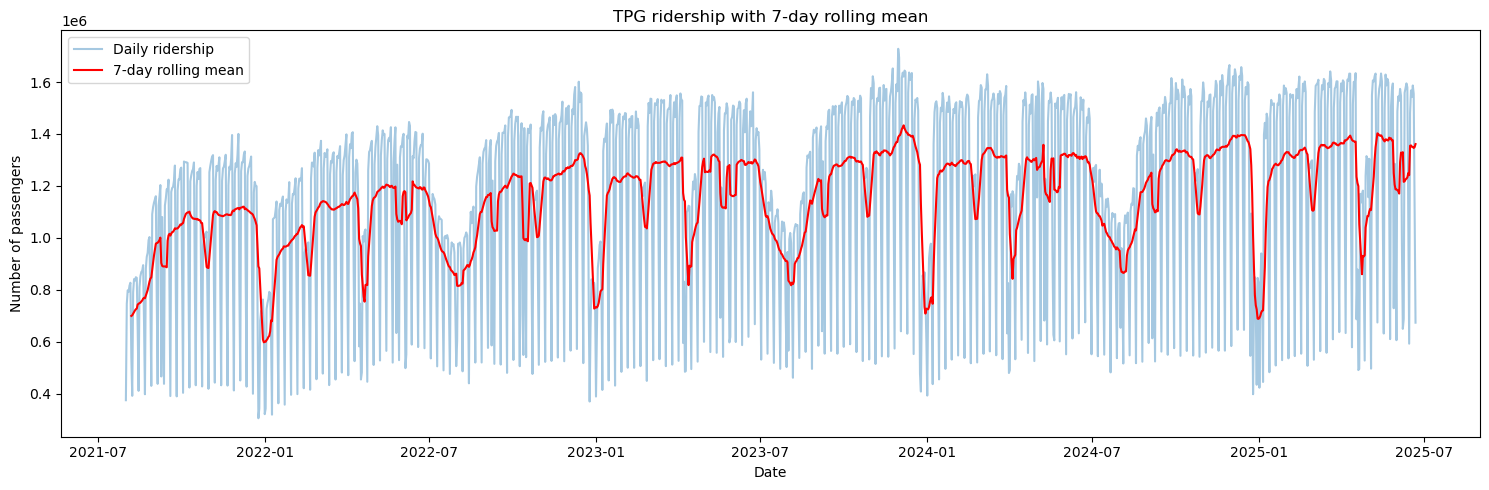

In [16]:
df['rolling_mean_7j'] = df['frequentation_totale'].rolling(window=7).mean()

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['frequentation_totale'], alpha=0.4, label='Daily ridership')
plt.plot(df.index, df['rolling_mean_7j'], color='red',  label='7-day rolling mean')
plt.title("TPG ridership with 7-day rolling mean")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.legend()
plt.tight_layout()
plt.show()

### Observation :  
The 7-day rolling mean smooths out the daily variations and highlights the underlying trend.  
We can clearly see:  
- the weekly pattern is reduced,  
- the recurring drops during vacation periods remain visible,  
- the overall upward trend from 2021 to 2025 is easier to observe.  

## Décomposition de la série temporelle (trend / seasonality / residual)

### Remark :  
I tried the seasonal decomposition, but I did not clearly see strong patterns in the graphs.  
The following analysis is based on ChatGPT’s interpretation of the decomposition results. 

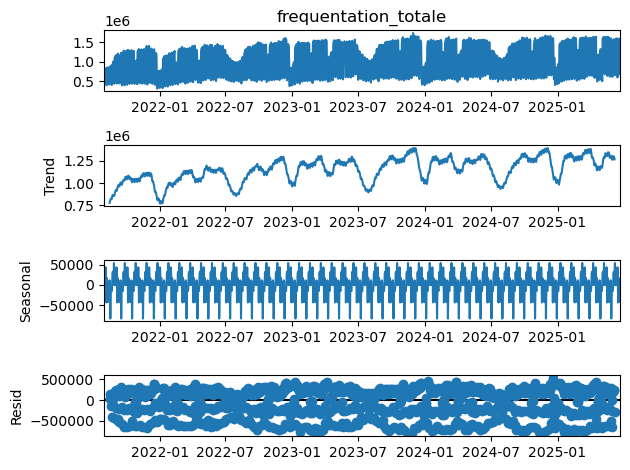

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['frequentation_totale'], model='additive', period=30)
decomp.plot()
plt.tight_layout()
plt.show()

### Explanation provided by ChatGPT from the graphs :  

1. **frequentation_totale (original series)**  
   - The original series: the “sawtooth” pattern remains due to the weekly cycle (drop during weekends).  
   - Longer seasonal drops are also visible: summer holidays, Christmas/New Year, etc.  

2. **Trend**  
   - The trend is smooth and consistent.  
   - It shows:  
     - a progressive increase from late 2021 until mid-2023,  
     - drops during summers and holiday periods,  
     - relatively stable ridership in 2024–2025, with a slight upward tendency.  
   - This provides a good basis for long-term forecasting (e.g., ARIMA or Prophet).  

3. **Seasonal**  
   - The repetitive pattern is clear: peaks and troughs appear roughly every 30 days.  
   - This likely reflects a monthly periodicity related to work / weekend / vacation cycles.  
   - The amplitudes are quite constant (~±50k), which is a good sign.  

4. **Residual**  
   - These are variations not explained by trend or seasonality.  
   - Some important spikes can be observed: these correspond to exceptional events.  
     - Possible causes: strikes, storms, public events, or measurement anomalies.  
   - To study them further, one could check the dates of these positive or negative peaks.  


## Analysis of temporal dependencies

The long-term graph shows repetitive effects.  
Do these effects also appear on a smaller scale?  
To investigate this, I will study the autocorrelation of the data.  

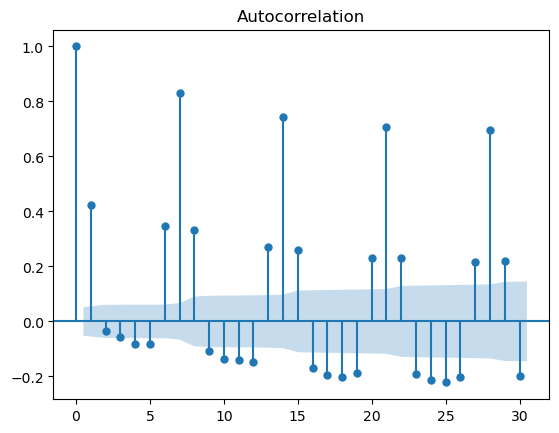

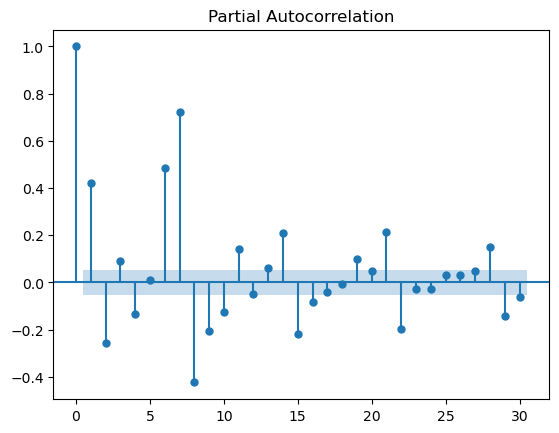

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['frequentation_totale'], lags=30)
plot_pacf(df['frequentation_totale'], lags=30)
plt.show()

## Autocorrelation Function (ACF)  

### Observation :  
The ACF plot shows the global correlations between daily passenger counts and their lagged values.  

- Significant peaks at lags 7, 14, 21, and 28 indicate a clear weekly periodicity.  
- This means that passenger counts on a given day are strongly correlated with the same weekday in previous weeks.  
- This is typical of human mobility patterns: commuting during weekdays and lower activity on weekends.  

There are strong weekly temporal dependencies, which supports: the use of lag features such as `frequentation_lag_7`, `frequentation_lag_14`, etc.,  
 

---

## Partial Autocorrelation Function (PACF)  

### Observation :  
The PACF plot shows the direct correlation between the series and its lags, after removing the effect of intermediate lags.  

- Lags 1, 7, and 8 are significant.  
- This means:  
  - Lag 1 (the previous day) has a strong direct impact.  
  - Lag 7 (the same weekday in the previous week) also plays a major role, consistent with the ACF results.  


These results suggest creating additional features to capture direct effects.

### Action :  
Create lag variables derived from the ACF/PACF analysis.  

In [19]:
global_daily_df['frequentation_totale_lag_1'] = global_daily_df['frequentation_totale'].shift(1)
global_daily_df['frequentation_totale_lag_7'] = global_daily_df['frequentation_totale'].shift(7)

# Moyenne glissante sur 7 jours (smoothing)
global_daily_df['rolling_mean_7d'] = global_daily_df['frequentation_totale'].rolling(window=7).mean()

# Supprimer les lignes avec des NaN
global_daily_df.dropna(subset=['frequentation_totale_lag_1', 'frequentation_totale_lag_7', 'rolling_mean_7d'], inplace=True)


# 4) Preparing the final datasets

### Observation :  
At the end of the EDA, two datasets were obtained: `TPG_meteo_all_df` and `global_daily_df`.  
- `global_daily_df` is designed to address global and daily-level problems.  
- `TPG_meteo_all_df` allows for a more detailed analysis of passenger counts.  

### Action :  
To ensure consistency between the two datasets, they will be enriched with cross-features:  
- `global_daily_df`: add daily weather, temporal variables, and logarithmic transformations.  
- `TPG_meteo_all_df`: add lagged variables.  

In [20]:
# load data from files
meteo_df_daily = pd.read_csv("meteo_daily.csv")
meteo_df_daily['time'] = pd.to_datetime(meteo_df_daily['time'])
meteo_df_daily = meteo_df_daily.rename(columns={"time": "date"})

In [21]:
# add weather
global_daily_df = global_daily_df.merge(meteo_df_daily[['date', 'weather_code']], on='date', how='left')

# transformation log
global_daily_df['log_frequentation_totale'] = np.log1p(global_daily_df['frequentation_totale'])
global_daily_df['log_frequentation_totale_lag_1'] = np.log1p(global_daily_df['frequentation_totale_lag_1'])
global_daily_df['log_frequentation_totale_lag_7'] = np.log1p(global_daily_df['frequentation_totale_lag_7'])
global_daily_df['log_rolling_mean_7d'] = np.log1p(global_daily_df['rolling_mean_7d'])

# Temporal variables
global_daily_df['indice_jour_semaine'] = global_daily_df['date'].dt.dayofweek
global_daily_df['indice_semaine'] = global_daily_df['date'].dt.isocalendar().week.astype(int)
global_daily_df['mois'] = global_daily_df['date'].dt.month
global_daily_df['annee'] = global_daily_df['date'].dt.year

global_daily_df['est_weekend'] = global_daily_df['indice_jour_semaine'].isin([5, 6]).astype(int)

In [22]:
if INSTALL_LIB:
   !pip install holidays

Collecting holidays
  Downloading holidays-0.76-py3-none-any.whl (1.1 MB)
     |████████████████████████████████| 1.1 MB 2.1 MB/s            
Requirement already satisfied: python-dateutil in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from holidays) (2.9.0)
Requirement already satisfied: six>=1.5 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from python-dateutil->holidays) (1.15.0)
Installing collected packages: holidays
Successfully installed holidays-0.76


In [23]:
# ajout d'une variable est_ferié
import holidays

# Create a dictionary of Swiss public holidays
ch_holidays = holidays.CH(subdiv='GE') 

# Create a column "est_ferie"
global_daily_df['est_ferie'] = global_daily_df['date'].isin(ch_holidays).astype(int)

In [24]:
TPG_meteo_all_df = TPG_meteo_all_df.sort_values(['arret_code_long', 'ligne', 'date'])

# Temporal variables
TPG_meteo_all_df['montees_lag_1'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_montees'].shift(1)
TPG_meteo_all_df["log_montees_lag_1"] = np.log1p(TPG_meteo_all_df["montees_lag_1"])

TPG_meteo_all_df['desc_lag_1'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_descentes'].shift(1)
TPG_meteo_all_df["log_desc_lag_1"] = np.log1p(TPG_meteo_all_df["desc_lag_1"])

TPG_meteo_all_df['montees_lag_7'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_montees'].shift(7)
TPG_meteo_all_df["log_montees_lag_7"] = np.log1p(TPG_meteo_all_df["montees_lag_7"])

TPG_meteo_all_df['desc_lag_7'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_descentes'].shift(7)
TPG_meteo_all_df["log_desc_lag_7"] = np.log1p(TPG_meteo_all_df["desc_lag_7"])

TPG_meteo_all_df['rolling_montees_7d'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_montees'].transform(lambda x: x.rolling(7).mean())
TPG_meteo_all_df["log_rolling_montees_7d"] = np.log1p(TPG_meteo_all_df["rolling_montees_7d"])

TPG_meteo_all_df['rolling_desc_7d'] = TPG_meteo_all_df.groupby(['arret_code_long', 'ligne'])['nb_de_descentes'].transform(lambda x: x.rolling(7).mean())
TPG_meteo_all_df["log_rolling_desc_7d"] = np.log1p(TPG_meteo_all_df["rolling_desc_7d"])

TPG_meteo_all_df['est_weekend'] = TPG_meteo_all_df['indice_jour_semaine'].isin([5, 6]).astype(int)

TPG_meteo_all_df = TPG_meteo_all_df.dropna().reset_index(drop=True)

In [25]:
# Create a column "est_ferie"
TPG_meteo_all_df['est_ferie'] = TPG_meteo_all_df['date'].isin(ch_holidays).astype(int)
TPG_meteo_all_df["est_ferie"] = TPG_meteo_all_df["est_ferie"].astype(int)

In [26]:
display(TPG_meteo_all_df.info())
TPG_meteo_all_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4794267 entries, 0 to 4794266
Data columns (total 33 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   ligne                        object        
 2   ligne_type_act               object        
 3   horaire_type                 object        
 4   arret_code_long              object        
 5   indice_semaine               int64         
 6   indice_jour_semaine          int64         
 7   nb_de_montees                float64       
 8   nb_de_descentes              float64       
 9   annee                        int64         
 10  mois                         int64         
 11  log_montees                  float64       
 12  log_descentes                float64       
 13  frequentation_totale         float64       
 14  log_frequentation_totale     float64       
 15  delta_montees_descentes      float64       
 16  

None

date                           0
ligne                          0
ligne_type_act                 0
horaire_type                   0
arret_code_long                0
indice_semaine                 0
indice_jour_semaine            0
nb_de_montees                  0
nb_de_descentes                0
annee                          0
mois                           0
log_montees                    0
log_descentes                  0
frequentation_totale           0
log_frequentation_totale       0
delta_montees_descentes        0
log_delta_montees_descentes    0
type_vehicule                  0
weather_code                   0
montees_lag_1                  0
log_montees_lag_1              0
desc_lag_1                     0
log_desc_lag_1                 0
montees_lag_7                  0
log_montees_lag_7              0
desc_lag_7                     0
log_desc_lag_7                 0
rolling_montees_7d             0
log_rolling_montees_7d         0
rolling_desc_7d                0
log_rollin

In [27]:
display(global_daily_df.info())
global_daily_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415 entries, 0 to 1414
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            1415 non-null   datetime64[ns]
 1   nb_de_montees                   1415 non-null   float64       
 2   nb_de_descentes                 1415 non-null   float64       
 3   frequentation_totale            1415 non-null   float64       
 4   frequentation_totale_lag_1      1415 non-null   float64       
 5   frequentation_totale_lag_7      1415 non-null   float64       
 6   rolling_mean_7d                 1415 non-null   float64       
 7   weather_code                    1415 non-null   int64         
 8   log_frequentation_totale        1415 non-null   float64       
 9   log_frequentation_totale_lag_1  1415 non-null   float64       
 10  log_frequentation_totale_lag_7  1415 non-null   float64       
 11  log_

None

date                              0
nb_de_montees                     0
nb_de_descentes                   0
frequentation_totale              0
frequentation_totale_lag_1        0
frequentation_totale_lag_7        0
rolling_mean_7d                   0
weather_code                      0
log_frequentation_totale          0
log_frequentation_totale_lag_1    0
log_frequentation_totale_lag_7    0
log_rolling_mean_7d               0
indice_jour_semaine               0
indice_semaine                    0
mois                              0
annee                             0
est_weekend                       0
est_ferie                         0
dtype: int64

## Exporting the datasets

In [28]:
# Save data to file
file_name = "TPG_daily_df.csv"
TPG_meteo_all_df.to_csv(file_name, index=False)

In [29]:
# Save data to file
file_name = "global_daily_df.csv"
global_daily_df.to_csv(file_name, index=False)

# 5) Weather impact analysis

Is there a correlation between ridership and weather?  

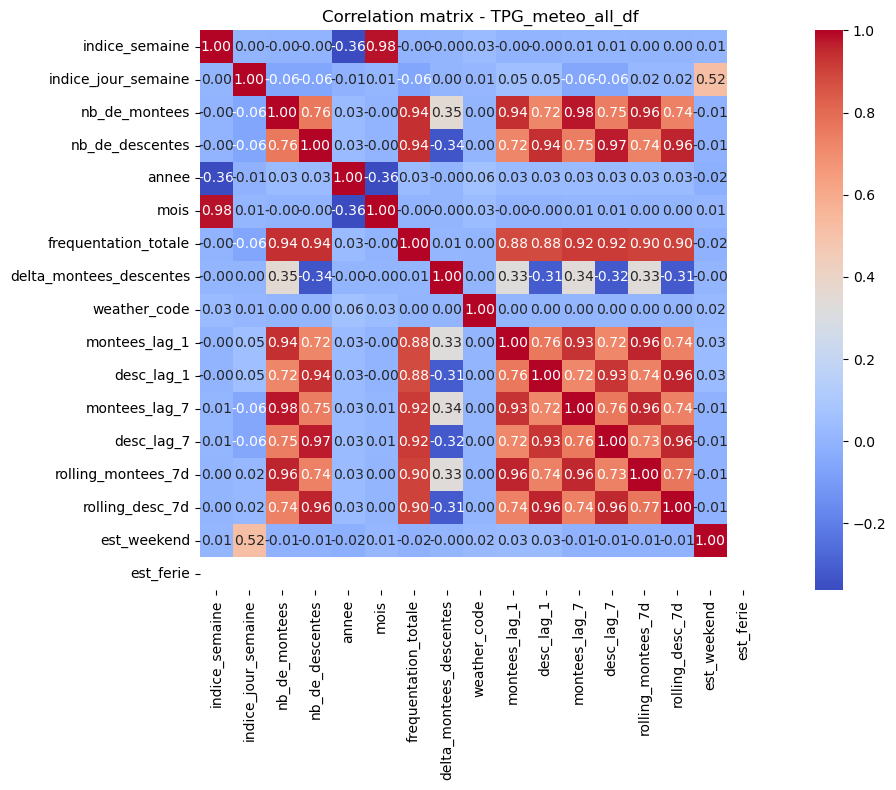

In [30]:
# Select only numerical columns (excluding datetime)
df_corr = (TPG_meteo_all_df
           .select_dtypes(include=['float64', 'int64'])
           .drop(columns=[col for col in TPG_meteo_all_df.columns if col.startswith("log_")])
           .corr(method='pearson'))

# Display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation matrix - TPG_meteo_all_df")
plt.tight_layout()
plt.show()

### Observation :  
There is a strong correlation (0.97–0.98) between `nb_de_montees` / `nb_de_descentes` and their lagged or rolling mean versions.  

The `weather_code` variable remains very weakly correlated with the others (<0.1).  
This is expected: weather effects are often non-linear or context-dependent, and not necessarily well captured by Pearson correlation.  

### Conclusion :  
The potential impact of weather on the models will be examined in the next chapter.  


In [31]:
#end